In [30]:
%pip install pandas

import pandas as pd # Version 2.2.3

file_path = "BBM409_S25_PA1_Dataset_v1/part_i.csv"
df = pd.read_csv(file_path)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
%pip install numpy scikit-learn matplotlib seaborn
# !pip install numpy scikit-learn matplotlib seaborn

import numpy as np # Version 2.0.2

# To visualize
import matplotlib.pyplot as plt # Version 3.9.4
import seaborn as sns # Version 0.13.2

import time

# scikit-learn Version 1.6.1
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# **Part I: Textual Data Analysis ✍🏻**

In [32]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns  # Select numeric columns
categorical_cols = df.select_dtypes(exclude=['number']).columns  # Select categorical columns (CLASS)

# Number of numerical and categorical columns
num_numerical_features = len(numeric_cols)
num_categorical_features = len(categorical_cols)

print(f"Total numerical features: {num_numerical_features}")
print(f"Total categorical features: {num_categorical_features}")

Total numerical features: 106
Total categorical features: 1



Missing values in categorical columns:
 Series([], dtype: int64)


/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_70076/467487882.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_missing_numerical.index, y=top_missing_numerical.values, hue=None, legend=False, palette="viridis")


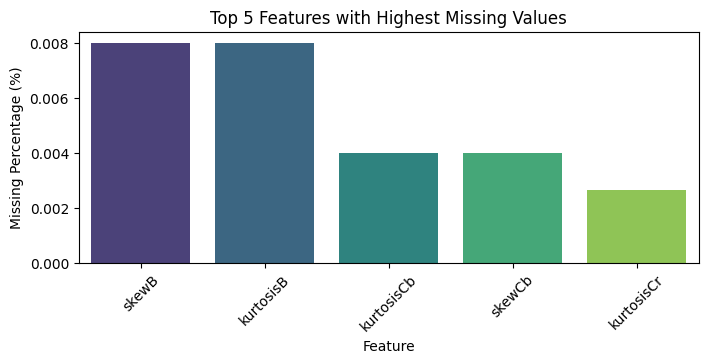

In [33]:
# Check for missing values in categorical columns
missing_categorical = df[categorical_cols].isnull().sum()
print("\nMissing values in categorical columns:\n", missing_categorical[missing_categorical > 0])

# Calculate missing percentage for numerical columns
missing_numerical_percentages = (df[numeric_cols].isnull().sum() / len(df)) * 100

# List the top 5 numerical features with the highest missing percentage
top_missing_numerical = missing_numerical_percentages.sort_values(ascending=False).head(5)

# 📊 Plot the top 5 missing features (Fixed Warning)
plt.figure(figsize=(8, 3))
sns.barplot(x=top_missing_numerical.index, y=top_missing_numerical.values, hue=None, legend=False, palette="viridis")
plt.xlabel("Feature")
plt.ylabel("Missing Percentage (%)")
plt.title("Top 5 Features with Highest Missing Values")
plt.xticks(rotation=45)
plt.show()

### **Handling Missing Values For Numerical Columns 🤔❓ (Mean Imputation)**  

In this assignment, we have decided to fill the missing values using the **mean imputation method** (i.e. completing the missing values with mean values). The dataset contains **106 numerical features and 75,000 samples**. Instead of checking the normality of each feature and deciding what to do with the each attribute's missing values, we have followed a more **pragmatic approach**. Individiually doing that for every attribute would be **time-consuming and inefficient**.

**In previous chart, we checked the missing value percentages** for each feature. If most of the features had extremely high percentages of missing values, We have considered handling it differently. As we can see the most percentage is less than 1%.

To conclude, since this project is **not** related to human life or a medical application, and the proportion of missing values **are lower than 1%**, using mean imputation is an efficient approach for handling missing data in this context.

In [34]:
# Apply mean imputation on numerical columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Merge the whole dataset
df_final = pd.concat([df[numeric_cols], df[categorical_cols]], axis=1)

# Verify missing values after imputation
missing_values_after = df_final.isnull().sum().sum()  # Total missing values
print(f"\nTotal missing values after mean imputation: {missing_values_after}")


Total missing values after mean imputation: 0


### **Visualizing the Difference Between Max and Min Values 📊**

When plotting the feature ranges (difference between min and max values), we noticed that **features with extremely large ranges dominate the visualization**, causing **small-range features to become nearly invisible**.

To **resolve this issue**, we applied **log transformation (`np.log1p`)** to the feature ranges. So this transformation, **prevents** the bigger differences to shadow the smaller ones and **provides** a better comparison.


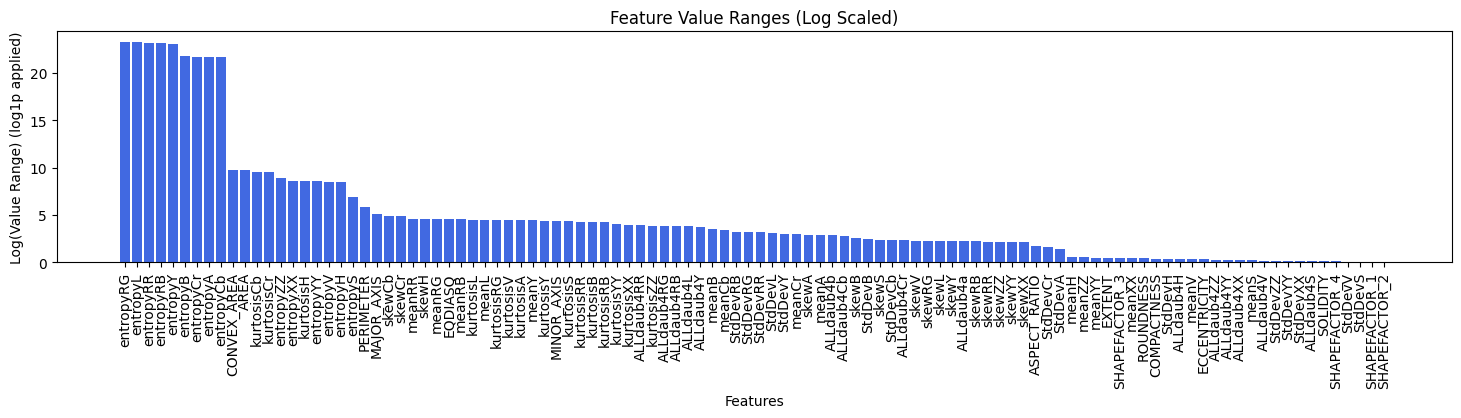

In [35]:
# Checking feature ranges
feature_ranges = df_final.iloc[:, :-1].agg(["min", "max"]).T
feature_ranges["range"] = feature_ranges["max"] - feature_ranges["min"]

# Sorting by range
feature_ranges = feature_ranges.sort_values(by="range", ascending=False)

# Apply log transformation to prevent small values from disappearing (values closer to 0 cannot be seen)
feature_ranges["log_range"] = np.log1p(feature_ranges["range"])

# Plot
plt.figure(figsize=(18, 3))
plt.bar(feature_ranges.index, feature_ranges["log_range"], color="royalblue")
plt.ylabel("Log(Value Range) (log1p applied)")
plt.xlabel("Features")
plt.title("Feature Value Ranges (Log Scaled)")
plt.xticks(rotation=90)
plt.show()

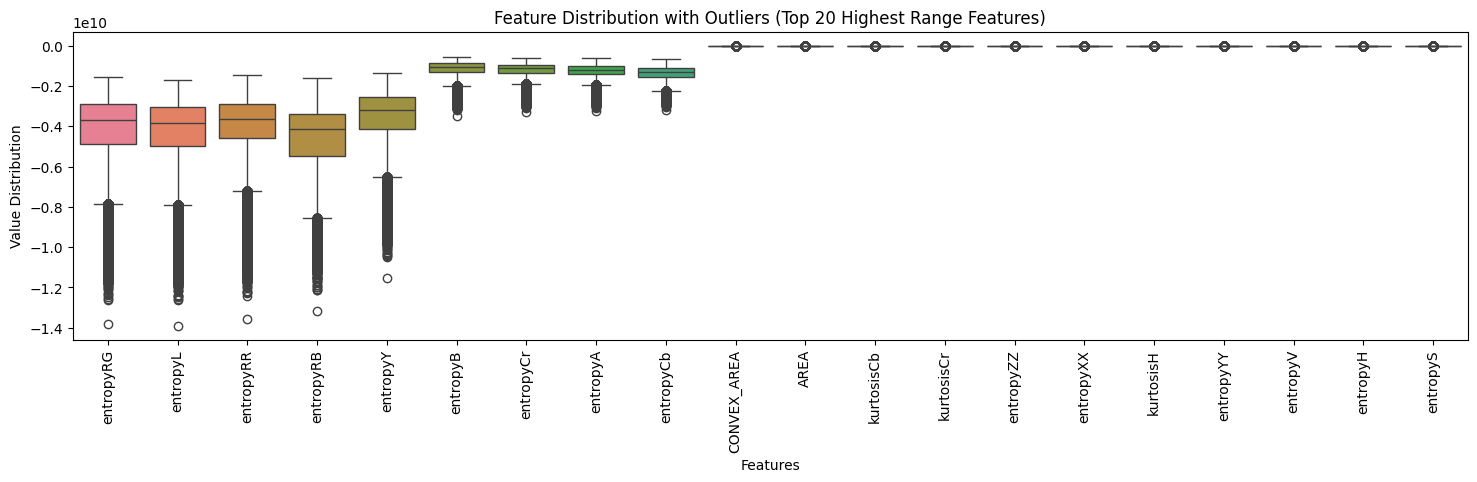

In [36]:
# Selecting a subset of features for visualization (Top 20 highest range features to avoid overcrowding)
selected_features = feature_ranges.index[:20]  # Taking the top 20 features with the highest range

# Creating a boxplot to visualize outliers
plt.figure(figsize=(18, 4))
sns.boxplot(data=df_final[selected_features])
plt.xticks(rotation=90)
plt.title("Feature Distribution with Outliers (Top 20 Highest Range Features)")
plt.xlabel("Features")
plt.ylabel("Value Distribution")
plt.show()

## **Handling Feature Scale Variation 🤔📊**  

As observed in the above **boxplot**, our dataset contains **highly different scales** and **many outliers**, such as in the features like `entropyRG`, `entropyL`, and `entropyRR`.

### **Why we have chosen RobustScaler to scale our data?**  
✔ **Handles outliers effectively** by using **median and IQR**, unlike StandardScaler, which is affected by extreme values. Since we have many outliers particular attributes, we have decided to use RobustScaler.

✔ **Prevents large-magnitude features from dominating** while maintaining meaningful distributions.

✔ **Provides more stability than MinMaxScaler**, which is sensitive to extreme minimum and maximum values.

**In Conclusion,** because of the multiple outliers, we have chosen **RobustScaler** to ensure stable feature scaling without being overly affected by extreme values.

### **Example Scaling for the entropyRG Feature**
We have selected **entropyRG** as an example feature and applied RobustScaler without altering the original data distribution.  
  This feature was chosen because it contains outliers, making it a great candidate to demonstrate how RobustScaler effectively handles extreme values.
This ensures that we only scale the feature values while preserving the overall shape and structure of the data.

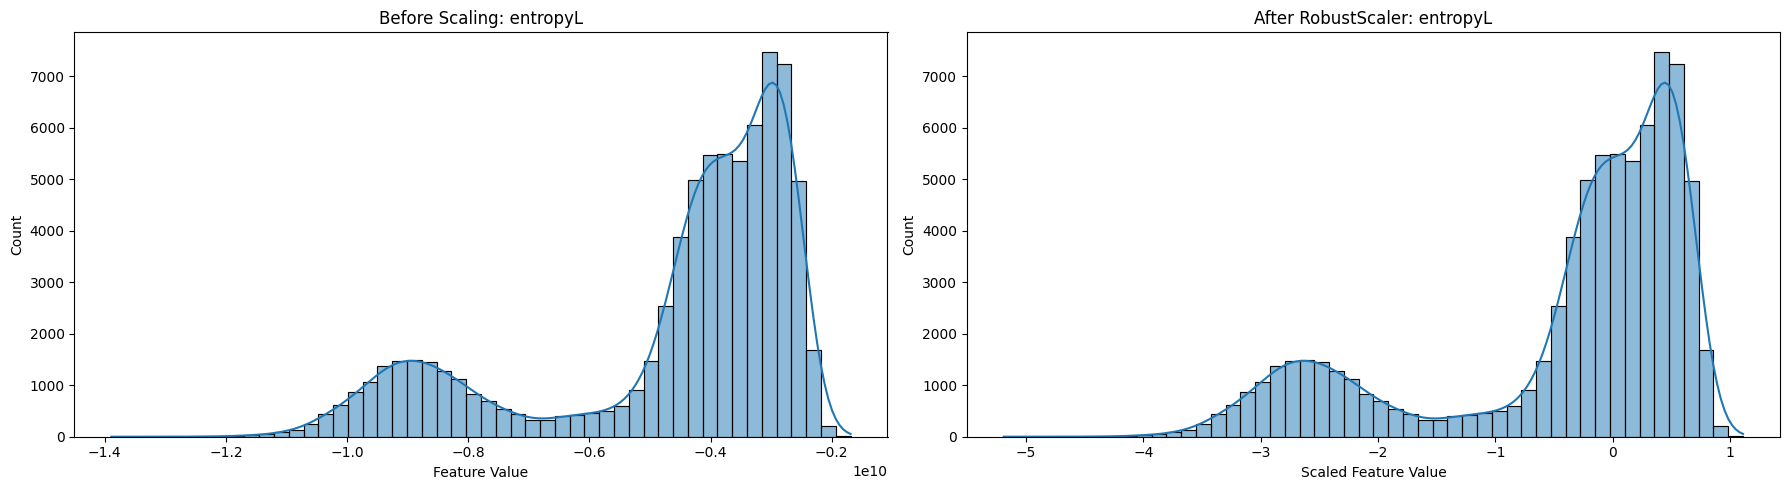

In [37]:
# Select original data (excluding CLASS column)
X_original = df_final.iloc[:, :-1]  # Exclude the target column (CLASS)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_original)  # Scale all numerical features

# Select entropyL as the feature to visualize scaling effects
feature_name = "entropyL"
feature_index = df_final.columns.get_loc(feature_name)

# 📊 BEFORE & AFTER SCALING VISUALIZATION
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# BEFORE SCALING (Original Data)
sns.histplot(X_original.iloc[:, feature_index], bins=50, kde=True, ax=ax[0])
ax[0].set_title(f"Before Scaling: {feature_name}")
ax[0].set_xlabel("Feature Value")
ax[0].set_ylabel("Count")

# AFTER SCALING (Using RobustScaler)
sns.histplot(X_scaled[:, feature_index], bins=50, kde=True, ax=ax[1])
ax[1].set_title(f"After RobustScaler: {feature_name}")
ax[1].set_xlabel("Scaled Feature Value")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## **Splitting Train and Test 🚂** (with shuffle)

In [38]:
# Split dataset into train and test sets (Shuffle is enabled)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df_final.iloc[:, -1], test_size=0.2, stratify=df_final.iloc[:, -1], shuffle=True, random_state=42
)

In [39]:
from sklearn.model_selection import cross_validate

# Define models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Weighted KNN": KNeighborsClassifier(n_neighbors=5, weights='distance'),    
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear")
}

# Train and Evaluate Each Model Separately to see the each time taken
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    start_time = time.time()  # Measure start time

    # Cross-validation
    cv_scores = cross_validate(
        model, X_train, y_train, cv=kf, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"]
    )

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Measure end time
    end_time = time.time()
    training_time = end_time - start_time

    # Store results
    results[model_name] = {
        "Training Time": time.time() - start_time,
        "CV Accuracy Mean": np.mean(cv_scores["test_accuracy"]),
        "CV Precision Mean": np.mean(cv_scores["test_precision_macro"]),
        "CV Recall Mean": np.mean(cv_scores["test_recall_macro"]),
        "CV F1 Score Mean": np.mean(cv_scores["test_f1_macro"]),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1 Score": f1_score(y_test, y_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Convert Results to DataFrame for Visualization
results_df = pd.DataFrame(results).T

## **Model Training Time Comparison ⏳**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_70076/2311424380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")


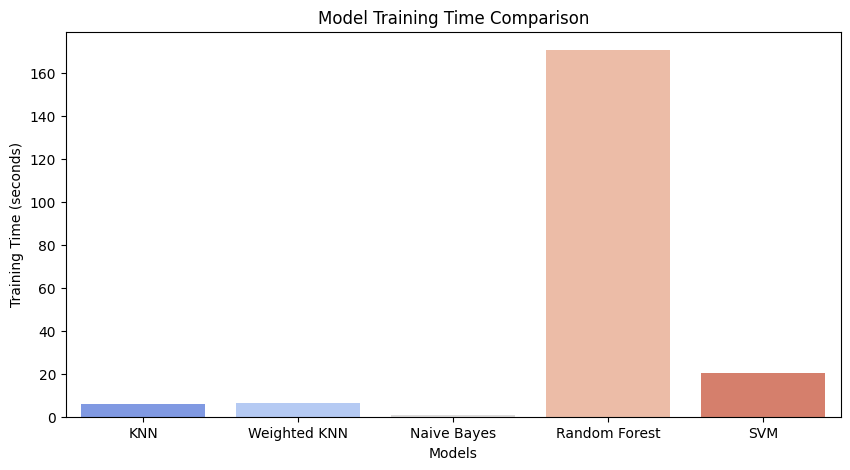

In [40]:
# Plot Training Time Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Models")
plt.show()

## **Model Accuracy Comparison 🎯**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_70076/2073402169.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")


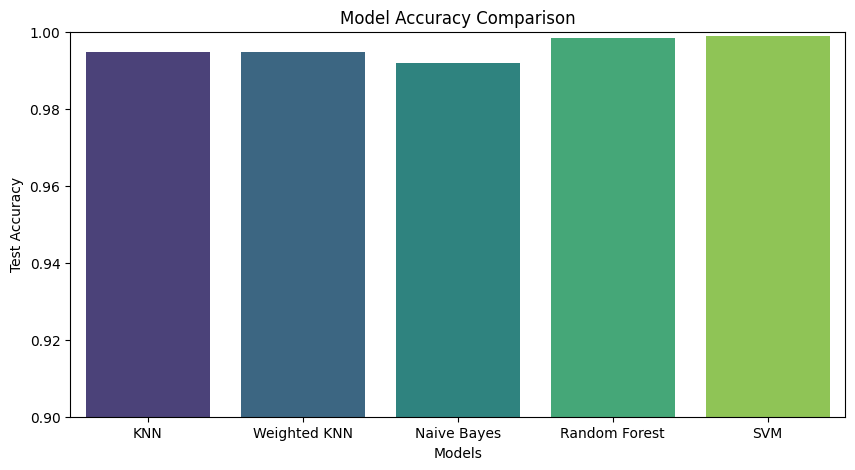

In [41]:
# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Models")
plt.ylim(0.9, 1)  # Zoom into accuracy range
plt.show()

## **Model Performance Metrics 📊**

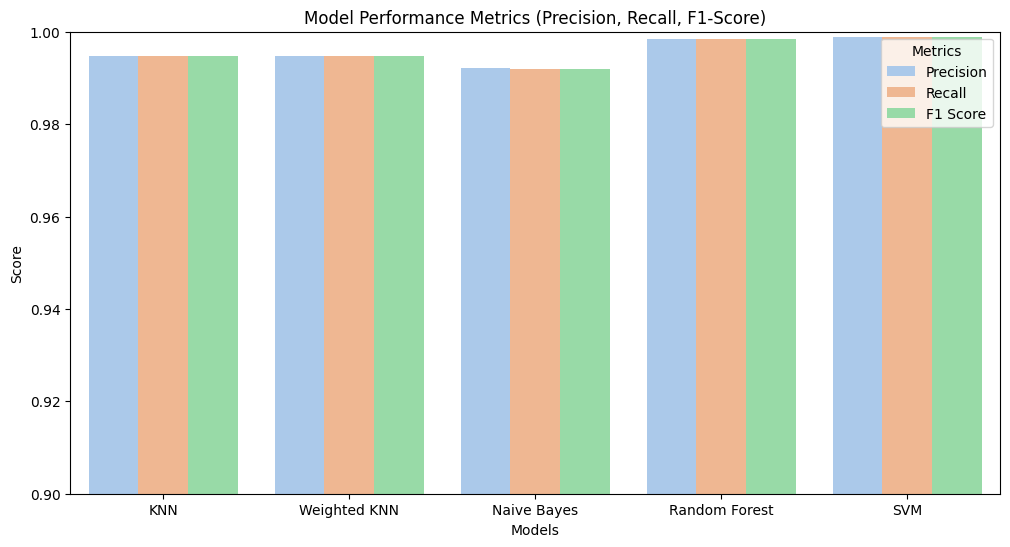

KNN              0.994667
Weighted KNN     0.994733
Naive Bayes         0.992
Random Forest    0.998333
SVM              0.998933
Name: Test Accuracy, dtype: object
KNN               0.99468
Weighted KNN     0.994746
Naive Bayes      0.992084
Random Forest    0.998335
SVM              0.998934
Name: Precision, dtype: object
KNN              0.994667
Weighted KNN     0.994733
Naive Bayes         0.992
Random Forest    0.998333
SVM              0.998933
Name: Recall, dtype: object
KNN              0.994671
Weighted KNN     0.994738
Naive Bayes      0.992007
Random Forest    0.998334
SVM              0.998933
Name: F1 Score, dtype: object


In [42]:
# Plot Precision, Recall, and F1 Score Comparison
metrics = ["Precision", "Recall", "F1 Score"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="Metrics")
plt.show()

print(results_df["Test Accuracy"])
print(results_df["Precision"])
print(results_df["Recall"])
print(results_df["F1 Score"])

## **Model Comparison Table for Part 1️⃣ 🧐**

| Model         | Test Accuracy | Precision  | Recall     | F1 Score   |
|---------------|---------------|------------|------------|------------|
| KNN           | 0.994667      | 0.994680   | 0.994667   | 0.994671   |
| Weighted KNN  | 0.994733      | 0.994746   | 0.994733   | 0.994738   |
| Naive Bayes   | 0.992000      | 0.992084   | 0.992000   | 0.992007   |
| Random Forest | 0.998333      | 0.998335   | 0.998333   | 0.998334   |
| SVM           | 0.998933      | 0.998934   | 0.998933   | 0.998933   |


## **Confusion Matrices for Models 🤯**

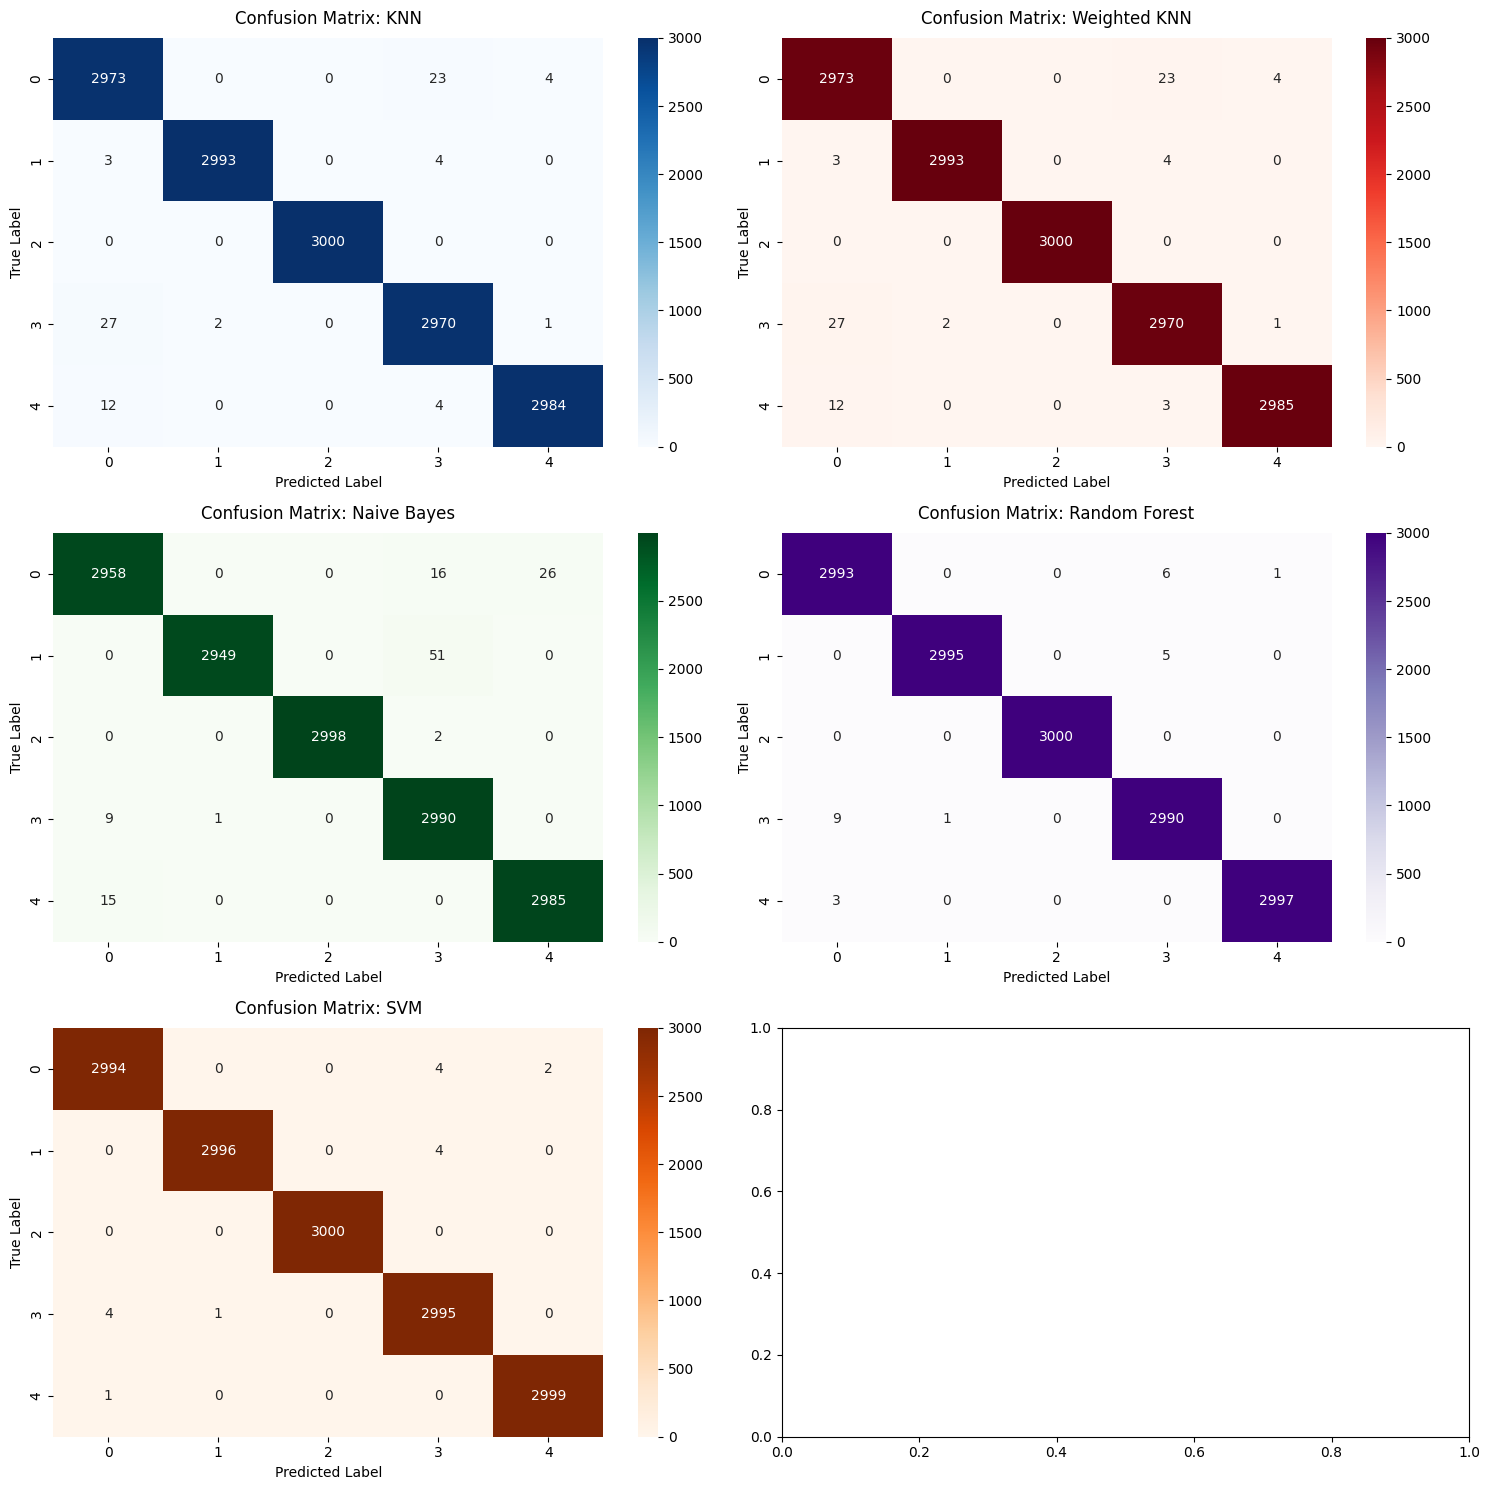

In [43]:
# Define color palettes for different models
color_maps = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'YlOrBr']

# Plot Confusion Matrices for Each Model
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=color_maps[i], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}", pad=10)
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()

# **Part II: Image Data Analysis 📸**

In [44]:
%pip install opencv-python tqdm

import os
import cv2 # Version 4.11.0.86
from tqdm import tqdm # Version 4.67.1

# Base directory and labels
data_dir = "BBM409_S25_PA1_Dataset_v1/part_ii"
labels = {"Arborio": 0, "Basmati": 1, "Ipsala": 2, "Jasmine": 3, "Karacadag": 4}

# Check if preprocessed data exists
cache_file = "processed_data.npz"

if os.path.exists(cache_file):
    # Load from cache
    print("⚡️ Loading preprocessed RGB data...")
    data = np.load(cache_file)
    X, y = data['X'], data['y']
else:
    # Process and save the data
    print("⏳ Processing RGB images and saving to cache...")
    features, targets = [], []

    start_time = time.time()

    for rice_type in tqdm(labels):
        rice_dir = os.path.join(data_dir, rice_type)
        for img_file in os.scandir(rice_dir):
            if img_file.name.endswith(".jpg"):
                try:
                    img = cv2.imread(img_file.path)
                    if img is None:
                        print(f"⚠️ Skipping invalid image: {img_file.path}")
                        continue  # Skip if image is invalid

                    img = cv2.resize(img, (32, 32))

                    # Extract RGB Mean features
                    img_float = img.astype(np.float32)
                    r_mean = np.mean(img_float[:, :, 0])
                    g_mean = np.mean(img_float[:, :, 1])
                    b_mean = np.mean(img_float[:, :, 2])

                    # Grayscale for contour detection
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
                    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    # Initialize features
                    aspect_ratio = orientation = area = perimeter = circularity = 0
                    hu_moments = np.zeros(7)

                    if contours:
                        cnt = max(contours, key=cv2.contourArea)
                        x, y_coord, w, h = cv2.boundingRect(cnt)
                        aspect_ratio = float(w) / h if h != 0 else 0
                        
                        if len(cnt) >= 5:
                            ellipse = cv2.fitEllipse(cnt)
                            orientation = ellipse[2]
                        
                        area = cv2.contourArea(cnt)
                        perimeter = cv2.arcLength(cnt, True)
                        circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter != 0 else 0
                        hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()

                        # Append only if valid contour is found
                        features.append([r_mean, g_mean, b_mean, aspect_ratio, orientation, area, perimeter, circularity, *hu_moments])
                        targets.append(labels[rice_type])

                    else:
                        print(f"⚠️ No contour found for image: {img_file.path}")

                except Exception as e:
                    print(f"Error processing image {img_file.path}: {e}")

    # Validate feature and target length
    assert len(features) == len(targets), "⚠️ Mismatch in features and targets length!"

    # Convert to NumPy arrays and save to cache
    X = np.array(features, dtype=np.float32)
    y = np.array(targets)

    np.savez_compressed(cache_file, X=X, y=y)
    end_time = time.time()
    print(f"✅ Processing and saving completed in {end_time - start_time:.2f} seconds")

print(f"✅ Final RGB dataset shape: {X.shape}")
print(f"✅ Final label dataset shape: {y.shape}")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
⚡️ Loading preprocessed RGB data...
✅ Final RGB dataset shape: (75000, 15)
✅ Final label dataset shape: (75000,)


### **Image Preprocessing Strategy (RGB + Shape Features) 🎨**

#### **Why Use RGB and Shape Features?**  
- **RGB Mean Values** (`r_mean`, `g_mean`, `b_mean`): Color helps distincting rice types, providing key classification information.  
- **Shape Features**: Added features like **aspect ratio, orientation, area, perimeter, circularity**, and **Hu moments** to capture shape differences between rice types and make the features richer.

- Initially, grayscale and white pixel ratios were considered but slowed down processing without significant classification improvement.  
- Using **RGB and shape features** proved efficient and provided better feature variety for classification.

---

#### **⚡️ How Did We Optimize the Process?**  
1. **Image Resizing**: Resized images to `32x32` for making processing faster.  
2. **Contour Detection**: Extracted shape features from the largest contour in the image.  
3. **Valid Data Check**: Skipped images with no valid contours to avoid noise.  
4. **Optimized Data Types**: Used `np.float32` for faster computation and efficient memory use.  
5. **Data Caching**: Processed features were saved to a `.npz` file to avoid repeated processing.  

---

##### 🗂️ **Usage of a Cache File (`processed_data.npz`)**  
- The cache file is used to **speed up data loading** during assignment solving.  
- Instead of processing images repeatedly, features are saved once and loaded instantly later.  
- This makes model training and testing **faster and more efficient**.

In [45]:
# Load preprocessed data
data = np.load("processed_data.npz")
X, y = data['X'], data['y']

In [46]:
# Feature Names including all extracted features
feature_names = [
    "R_Mean", "G_Mean", "B_Mean",
    "Aspect_Ratio", "Orientation", "Area", "Perimeter", "Circularity",
    "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"
]

# Convert to DataFrame for easier analysis
X_df = pd.DataFrame(X, columns=feature_names)

# Check for null values in each feature
print("🔍 Null values per feature:")
print(X_df.isnull().sum())

# Check for NaN or infinite values as well
print("\n🔍 NaN values per feature:")
print(X_df.isna().sum())

print("\n🔍 Infinite values per feature:")
print(np.isinf(X_df).sum())

🔍 Null values per feature:
R_Mean          0
G_Mean          0
B_Mean          0
Aspect_Ratio    0
Orientation     0
Area            0
Perimeter       0
Circularity     0
Hu1             0
Hu2             0
Hu3             0
Hu4             0
Hu5             0
Hu6             0
Hu7             0
dtype: int64

🔍 NaN values per feature:
R_Mean          0
G_Mean          0
B_Mean          0
Aspect_Ratio    0
Orientation     0
Area            0
Perimeter       0
Circularity     0
Hu1             0
Hu2             0
Hu3             0
Hu4             0
Hu5             0
Hu6             0
Hu7             0
dtype: int64

🔍 Infinite values per feature:
R_Mean          0
G_Mean          0
B_Mean          0
Aspect_Ratio    0
Orientation     0
Area            0
Perimeter       0
Circularity     0
Hu1             0
Hu2             0
Hu3             0
Hu4             0
Hu5             0
Hu6             0
Hu7             0
dtype: int64


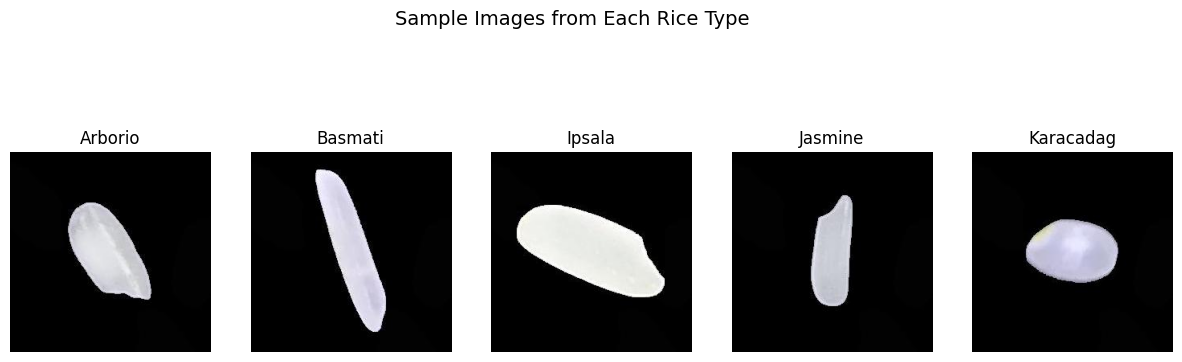

In [47]:
import random

# Load preprocessed data
data = np.load("processed_data.npz")
X, y = data['X'], data['y']

# Visualize Sample Images from Each Rice Type
rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
data_dir = "BBM409_S25_PA1_Dataset_v1/part_ii"

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for idx, rice_type in enumerate(rice_types):
    rice_dir = os.path.join(data_dir, rice_type)
    img_name = random.choice(os.listdir(rice_dir))  # Select a random image for each one
    img_path = os.path.join(rice_dir, img_name)
    
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper visualization
        axes[idx].imshow(img)
        axes[idx].set_title(rice_type)
        axes[idx].axis("off")
    except Exception as e:
        print(f"Error loading image: {e}")
        axes[idx].set_title(f"{rice_type}\n[Image Error]")
        axes[idx].axis("off")

plt.suptitle("Sample Images from Each Rice Type", fontsize=14)
plt.show()

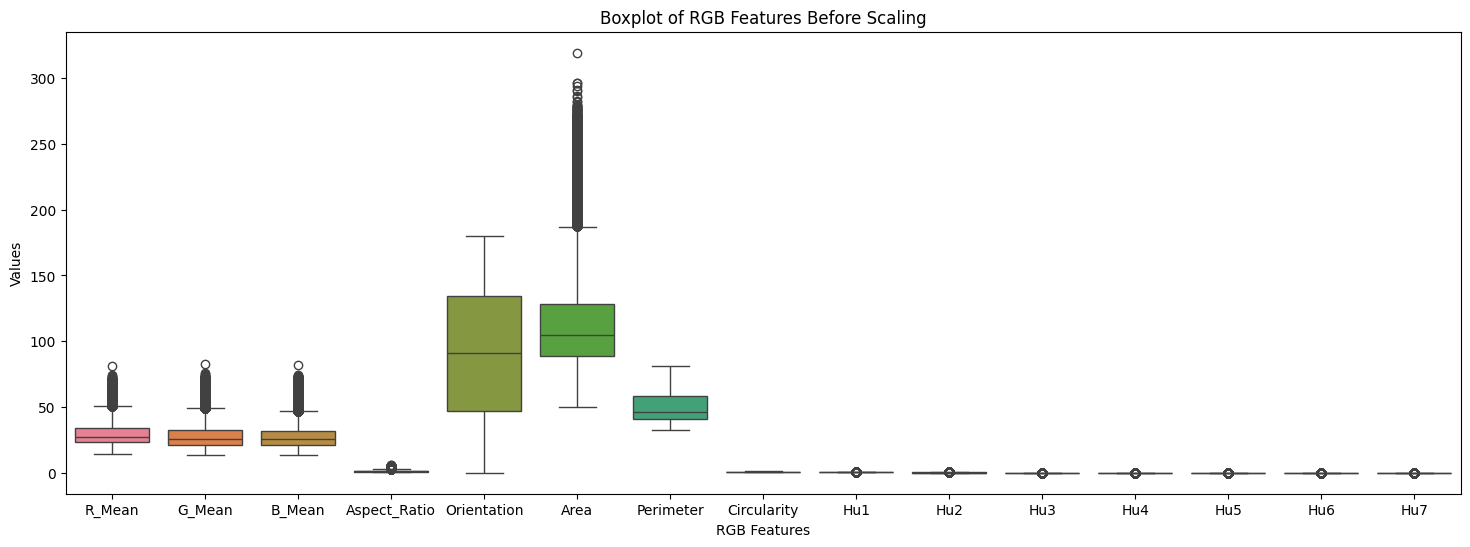

In [48]:
# Boxplot for Outlier Detection (Before Scaling)
df_original = pd.DataFrame(X, columns=["R_Mean", "G_Mean", "B_Mean",
    "Aspect_Ratio", "Orientation", "Area", "Perimeter", "Circularity",
    "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"])

plt.figure(figsize=(18, 6))
sns.boxplot(data=df_original)
plt.title("Boxplot of RGB Features Before Scaling")
plt.xlabel("RGB Features")
plt.ylabel("Values")
plt.show()

### ⚖️ **Why We Chose RobustScaler for Scaling Our Data?**  

- **RobustScaler** uses the **median** and **IQR** for scaling, making it **less sensitive to outliers**.  

- Models like **SVM** and **KNN** can be affected by large variations. RobustScaler helps ensure fair contribution from all features.  

- In the **above scaling boxplot**, features like `Area` had extreme outliers. RobustScaler handled these better than StandardScaler.  

- In the **after scaling boxplot**, the feature distributions became more consistent.  

- Since the dataset has outliers, **RobustScaler** was the best choice for stable and reliable scaling.

In [49]:
# Scaling Data using RobustScaler (Chosen after Outlier Analysis)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

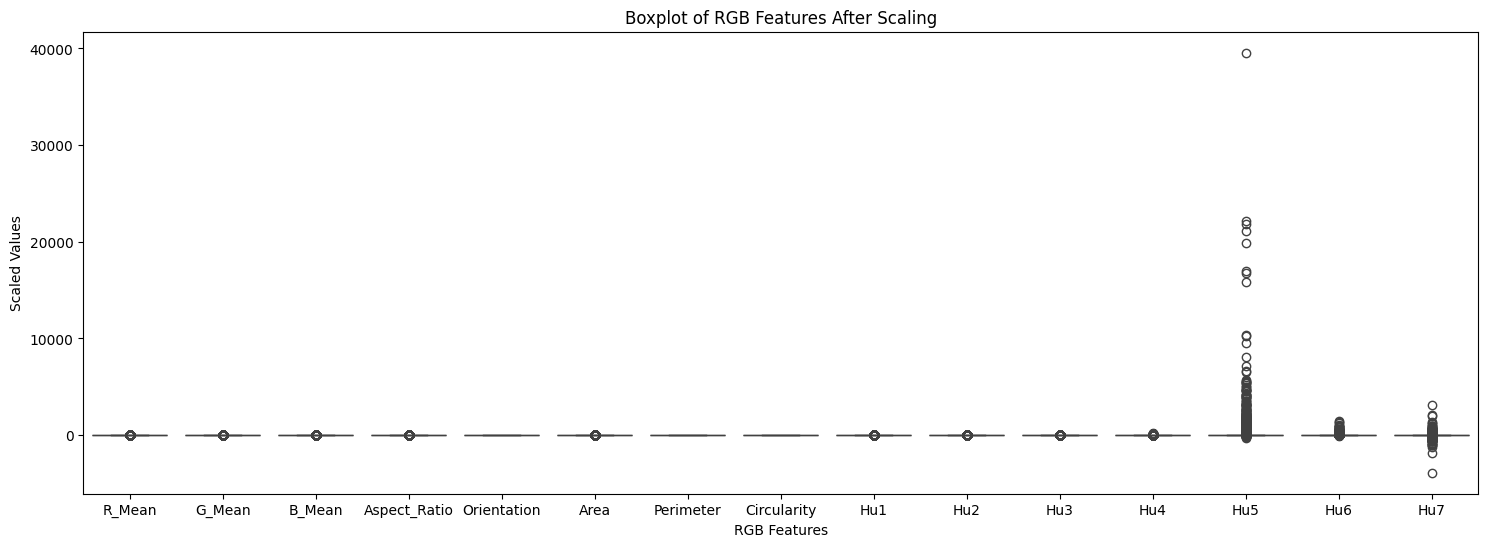

In [50]:
# Boxplot After Scaling to Confirm
df_scaled = pd.DataFrame(X_scaled, columns=["R_Mean", "G_Mean", "B_Mean",
    "Aspect_Ratio", "Orientation", "Area", "Perimeter", "Circularity",
    "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"])

plt.figure(figsize=(18, 6))
sns.boxplot(data=df_scaled)
plt.title("Boxplot of RGB Features After Scaling")
plt.xlabel("RGB Features")
plt.ylabel("Scaled Values")
plt.show()

## **Splitting Train and Test 🚂** (with shuffle)

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

In [52]:
# Defining models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Weighted KNN": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", random_state=42)
}

In [ ]:
# Train and Evaluate Each Model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    start_time = time.time()  # Measure start time

    cv_scores = cross_validate(
        model, X_train, y_train, cv=kf, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"]
    )

    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Store results
    results[model_name] = {
        "Training Time": time.time() - start_time,
        "CV Accuracy Mean": np.mean(cv_scores["test_accuracy"]),
        "CV Precision Mean": np.mean(cv_scores["test_precision_macro"]),
        "CV Recall Mean": np.mean(cv_scores["test_recall_macro"]),
        "CV F1 Score Mean": np.mean(cv_scores["test_f1_macro"]),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1 Score": f1_score(y_test, y_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

## **Model Training Time Comparison ⏳**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_70076/294861247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")


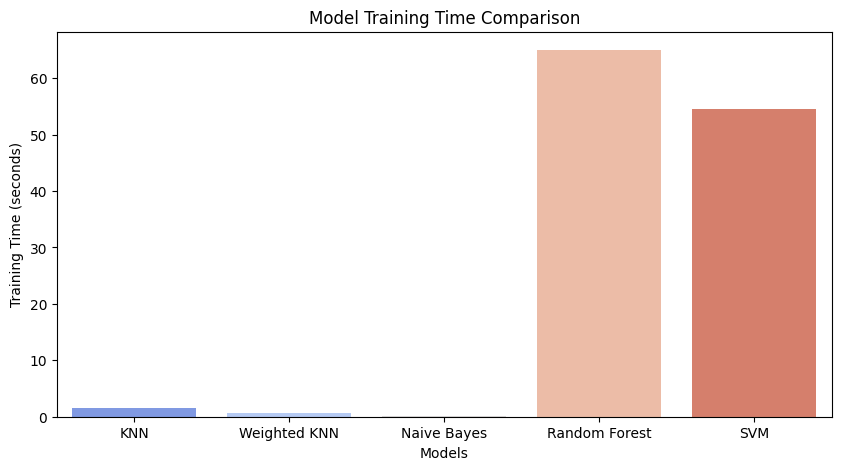

In [ ]:
# Training Time
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Models")
plt.show()

## **Model Accuracy Comparison 🎯**

/var/folders/tv/v5jdxc154fx7qdyd5fsmb4pr0000gn/T/ipykernel_70076/3510304477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")


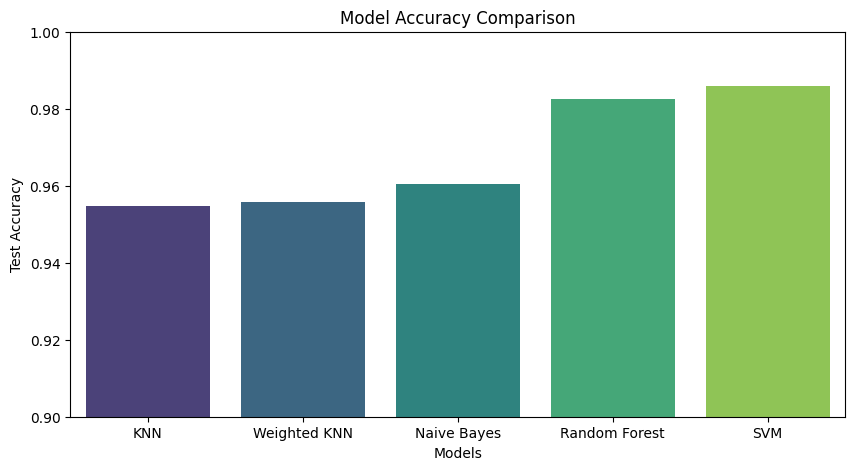

In [ ]:
# Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Test Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Models")
plt.ylim(0.9, 1)  # Zoom into accuracy range
plt.show()

## **Model Performance Metrics 📊**

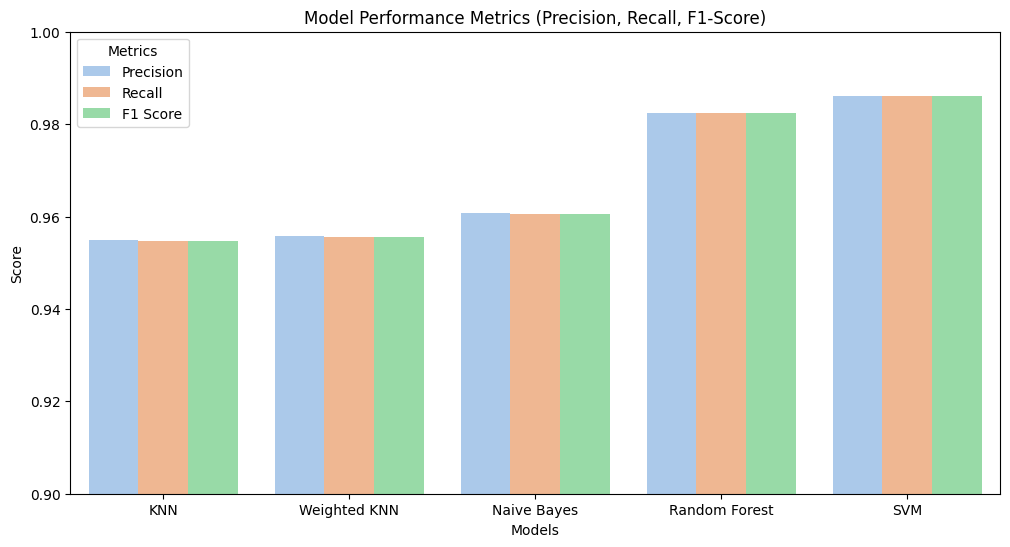

KNN              0.954733
Weighted KNN     0.955667
Naive Bayes      0.960467
Random Forest      0.9824
SVM                 0.986
Name: Test Accuracy, dtype: object
KNN              0.954894
Weighted KNN     0.955846
Naive Bayes      0.960766
Random Forest    0.982411
SVM              0.986072
Name: Precision, dtype: object
KNN              0.954733
Weighted KNN     0.955667
Naive Bayes      0.960467
Random Forest      0.9824
SVM                 0.986
Name: Recall, dtype: object
KNN              0.954664
Weighted KNN      0.95559
Naive Bayes      0.960499
Random Forest    0.982401
SVM              0.986003
Name: F1 Score, dtype: object


In [ ]:
# Plot Precision, Recall, and F1 Score Comparison
metrics = ["Precision", "Recall", "F1 Score"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="Metrics")
plt.show()

print(results_df["Test Accuracy"])
print(results_df["Precision"])
print(results_df["Recall"])
print(results_df["F1 Score"])

## **Model Comparison Table for Part 2️⃣ 🧐**

| Model         | Test Accuracy | Precision  | Recall     | F1 Score   |
|---------------|---------------|------------|------------|------------|
| KNN           | 0.954733      | 0.954894   | 0.954733   | 0.954664   |
| Weighted KNN  | 0.955667      | 0.955846   | 0.955667   | 0.955590   |
| Naive Bayes   | 0.960467      | 0.960766   | 0.960467   | 0.960499   |
| Random Forest | 0.982400      | 0.982411   | 0.982400   | 0.982401   |
| SVM           | 0.986000      | 0.986072   | 0.986000   | 0.986003   |


## **Confusion Matrices for Models 🤯**

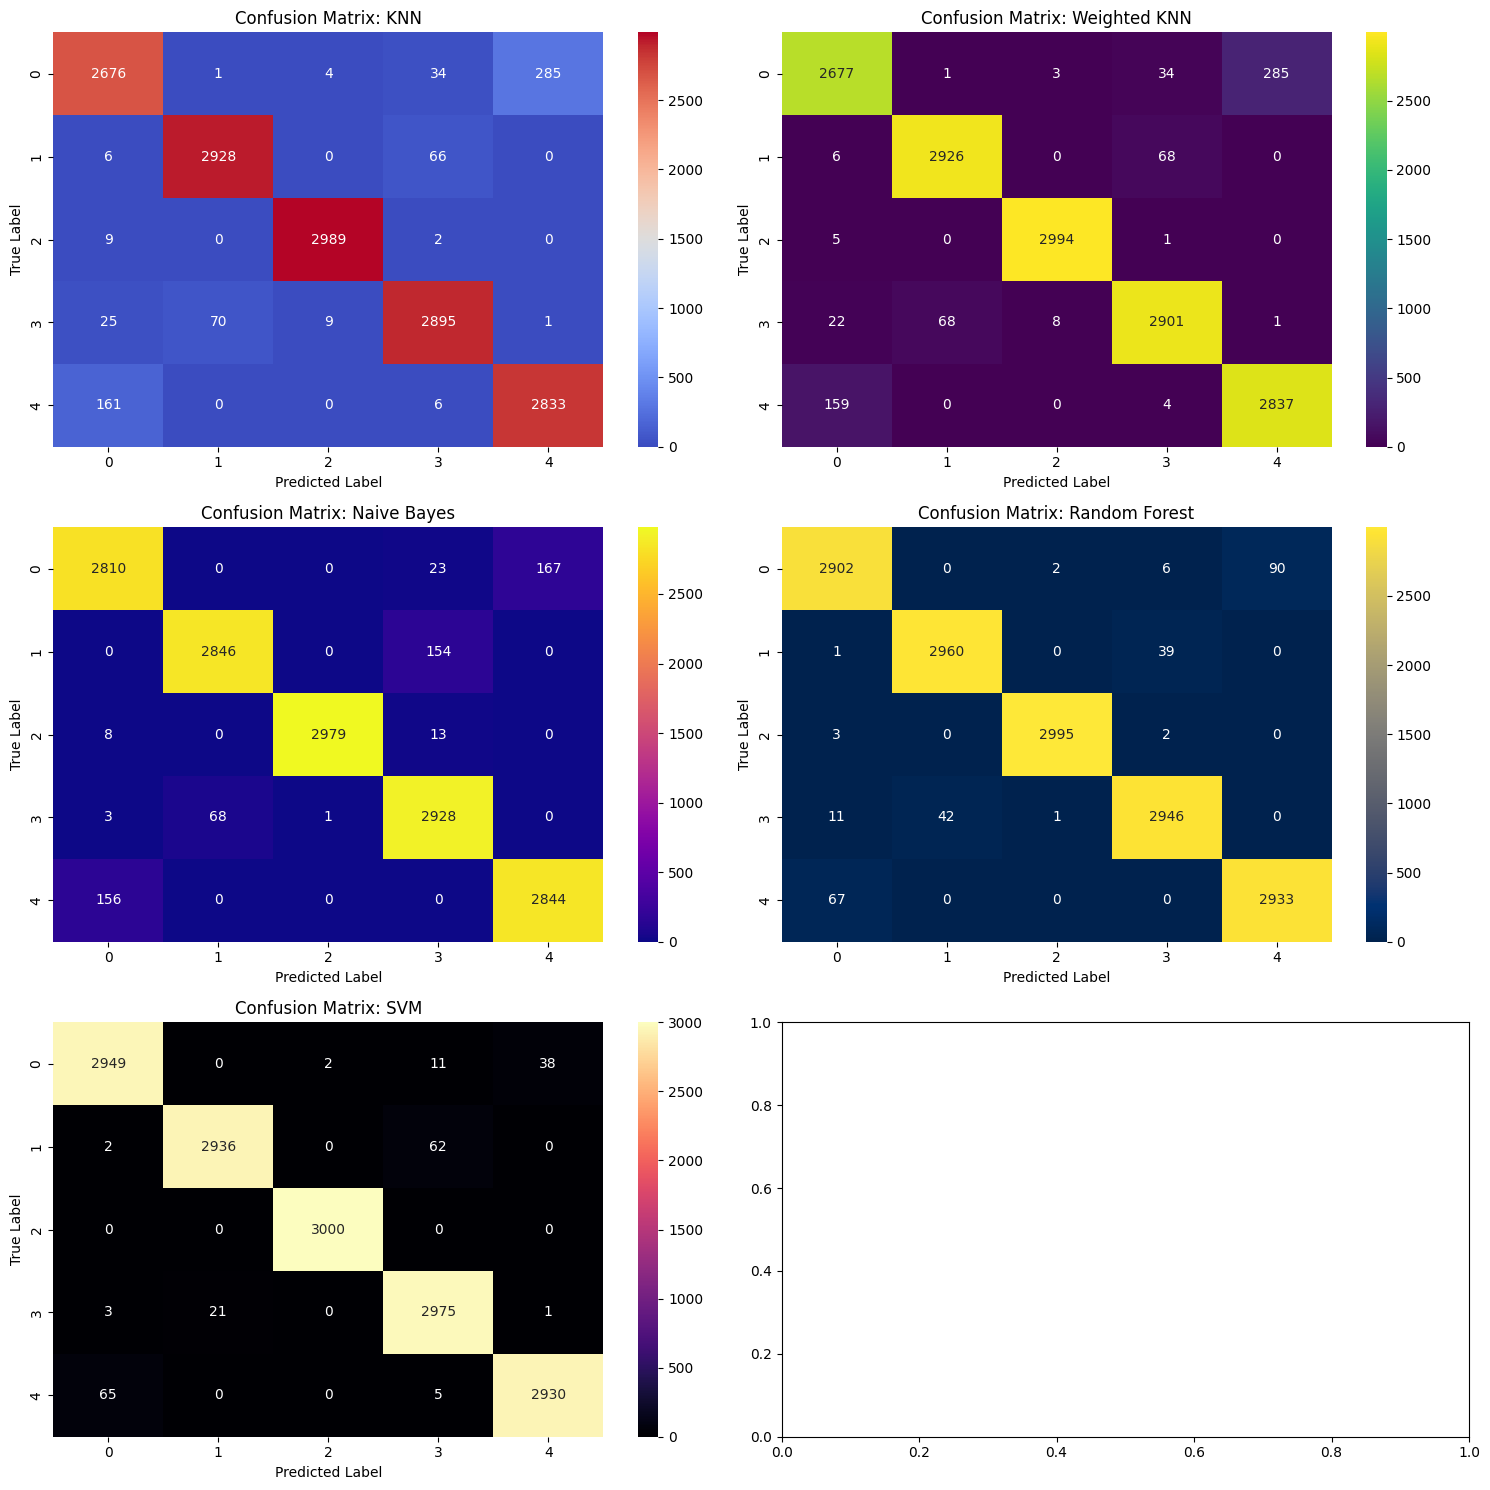

In [ ]:
color_maps = ['coolwarm', 'viridis', 'plasma', 'cividis', 'magma', 'inferno', 'YlGnBu']

# Plot Confusion Matrices for Each Model
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for i, (model_name, model) in enumerate(results.items()):
    sns.heatmap(model["Confusion Matrix"], annot=True, fmt="d", cmap=color_maps[i % len(color_maps)], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()